### What Causes an Accident to Involve Multiple Fatalities?

In [1]:
import shap
import warnings
import pandas as pd
import import_ipynb
from methods import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.metrics import classification_report #for model evaluation

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

importing Jupyter notebook from methods.ipynb


#### Read only accident data from 1995 - 2020 (14 years of data)

In [2]:
FARSpath = "/data/fiona123/ProjectData_TrafficFatality/"
d = {}
d['accident'] = read_accidentdata(FARSpath, d)
print(d.keys())

/data/fiona123/ProjectData_TrafficFatality/FARS2015NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2013NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2016NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2012NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2020NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2005NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2010NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS1995NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2018NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2014NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2019NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2017NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2000NationalCSV
/data/fiona123/ProjectData_TrafficFatality/FARS2011NationalCSV
dict_keys(['2015_accident', '2013_ACCIDENT', '2016_accident', '2012_ACCIDENT', '2020_accident', '2005_ACCIDENT', '2010

In [3]:
d['accident'].head(5)

,STATE,STATENAME,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERSONS,PERMVIT,PERNOTMVIT,COUNTY,CITY,DAY,DAYNAME,MONTH,MONTHNAME,YEAR,DAY_WEEK,DAY_WEEKNAME,HOUR,HOURNAME,MINUTE,MINUTENAME,NHS,NHSNAME,ROUTE,ROUTENAME,TWAY_ID,TWAY_ID2,RUR_URB,RUR_URBNAME,FUNC_SYS,FUNC_SYSNAME,RD_OWNER,RD_OWNERNAME,MILEPT,MILEPTNAME,LATITUDE,LATITUDENAME,LONGITUD,LONGITUDNAME,SP_JUR,SP_JURNAME,HARM_EV,HARM_EVNAME,MAN_COLL,MAN_COLLNAME,RELJCT1,RELJCT1NAME,RELJCT2,RELJCT2NAME,TYP_INT,TYP_INTNAME,WRK_ZONE,WRK_ZONENAME,REL_ROAD,REL_ROADNAME,LGT_COND,LGT_CONDNAME,WEATHER1,WEATHER1NAME,WEATHER2,WEATHER2NAME,WEATHER,WEATHERNAME,SCH_BUS,SCH_BUSNAME,RAIL,RAILNAME,NOT_HOUR,NOT_HOURNAME,NOT_MIN,NOT_MINNAME,ARR_HOUR,ARR_HOURNAME,ARR_MIN,ARR_MINNAME,HOSP_HR,HOSP_HRNAME,HOSP_MN,HOSP_MNNAME,CF1,CF1NAME,CF2,CF2NAME,CF3,CF3NAME,FATALS,DRUNK_DR,ROAD_FNC,COUNTYNAME,CITYNAME,REL_JUNC,TRAF_FLO,NO_LANES,SP_LIMIT,ALIGNMNT,PROFILE,PAVE_TYP,SUR_COND,TRA_CONT,T_CONT_F,HIT_RUN,C_M_ZONE,latitude,longitud
0,1,Alabama,10001,1.0,1,0.0,0,1,1.0,0.0,127,0,1,1.0,1,January,2015,5,Thursday,2,2:00am-2:59am,40,40,0,This section IS NOT on the NHS,3,State Highway,SR-5,NaN,1.0,Rural,3.0,Principal Arterial - Other,1.0,State Highway Agency,1754.0,1754,33.878653,33.87865278,-87.325328,-87.32532778,0,No Special Jurisdiction,35,Embankment,0,Not a Collision with Motor Vehicle In-Transport,0.0,No,1.0,Non-Junction,1.0,Not an Intersection,0.0,None,4,On Roadside,2,Dark - Not Lighted,1.0,Clear,0.0,No Additional Atmospheric Conditions,1,Clear,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,2,2:00am-2:59am,58,58,88,Not Applicable (Not Transported),88,Not Applicable (Not Transported),0.0,None,0.0,None,0.0,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Alabama,10002,1.0,1,0.0,0,1,1.0,0.0,83,0,1,1.0,1,January,2015,5,Thursday,22,10:00pm-10:59pm,13,13,1,This section IS ON the NHS,1,Interstate,I-65,NaN,1.0,Rural,1.0,Interstate,1.0,State Highway Agency,3604.0,3604,34.910442,34.91044167,-86.908708,-86.90870833,0,No Special Jurisdiction,34,Ditch,0,Not a Collision with Motor Vehicle In-Transport,0.0,No,1.0,Non-Junction,1.0,Not an Intersection,0.0,None,3,On Median,2,Dark - Not Lighted,10.0,Cloudy,0.0,No Additional Atmospheric Conditions,10,Cloudy,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,22,10:00pm-10:59pm,20,20,88,Not Applicable (Not Transported),88,Not Applicable (Not Transported),0.0,None,0.0,None,0.0,None,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Alabama,10003,1.0,1,0.0,0,2,2.0,0.0,11,0,1,1.0,1,January,2015,5,Thursday,1,1:00am-1:59am,25,25,0,This section IS NOT on the NHS,2,U.S. Highway,US-SR 6,NaN,1.0,Rural,3.0,Principal Arterial - Other,1.0,State Highway Agency,1958.0,1958,32.142006,32.14200556,-85.758456,-85.75845556,0,No Special Jurisdiction,42,Tree (Standing Only),0,Not a Collision with Motor Vehicle In-Transport,0.0,No,1.0,Non-Junction,1.0,Not an Intersection,0.0,None,4,On Roadside,2,Dark - Not Lighted,1.0,Clear,0.0,No Additional Atmospheric Conditions,1,Clear,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,1,1:00am-1:59am,45,45,99,Unknown,99,Unknown EMS Hospital Arrival Time,0.0,None,0.0,None,0.0,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Alabama,10004,1.0,1,0.0,0,1,1.0,0.0,45,0,4,4.0,1,January,2015,1,Sunday,0,0:00am-0:59am,57,57,0,This section IS NOT on the NHS,3,State Highway,SR-27,NaN,1.0,Rural,4.0,Minor Arterial,1.0,State Highway Agency,566.0,566,31.439814,31.43981389,-85.510300,-85.5103,0,No Special Jurisdiction,53,Mail Box,0,Not a Collision with Motor Vehicle In-Transport,0.0,No,1.0,Non-Junction,1.0,Not an Intersection,0.0,None,4,On Roadside,2,Dark - Not Lighted,10.0,Cloudy,0.0,No Additional Atmospheric Conditions,10,Cloudy,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,1,1:00am-1:59am,15,15,88,Not Applicable (Not Transported),88,Not Applicable (Not Transported),0.0,None,0.0,None,0.0,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Alabama,10005,2.0

#### Choose important features to keep

In [4]:
cols_to_keep = ["DAY", "MONTH", "YEAR", "DAY_WEEKNAME", "HOUR", "NHSNAME", "ROUTENAME", "RUR_URBNAME",
               "HARM_EVNAME", "TYP_INTNAME", "REL_ROADNAME", "LGT_CONDNAME", "WEATHERNAME", "LATITUDE",
               "LONGITUD", "DRUNK_DR", "FATALS"]

d['accident'] = d['accident'][cols_to_keep]
d['accident'].head(5)

,DAY,MONTH,YEAR,DAY_WEEKNAME,HOUR,NHSNAME,ROUTENAME,RUR_URBNAME,HARM_EVNAME,TYP_INTNAME,REL_ROADNAME,LGT_CONDNAME,WEATHERNAME,LATITUDE,LONGITUD,DRUNK_DR,FATALS
0,1,1,2015,Thursday,2,This section IS NOT on the NHS,State Highway,Rural,Embankment,Not an Intersection,On Roadside,Dark - Not Lighted,Clear,33.878653,-87.325328,1,1
1,1,1,2015,Thursday,22,This section IS ON the NHS,Interstate,Rural,Ditch,Not an Intersection,On Median,Dark - Not Lighted,Cloudy,34.910442,-86.908708,0,1
2,1,1,2015,Thursday,1,This section IS NOT on the NHS,U.S. Highway,Rural,Tree (Standing Only),Not an Intersection,On Roadside,Dark - Not Lighted,Clear,32.142006,-85.758456,1,1
3,4,1,2015,Sunday,0,This section IS NOT on the NHS,State Highway,Rural,Mail Box,Not an Intersection,On Roadside,Dark - Not Lighted,Cloudy,31.439814,-85.510300,1,1
4,7,1,2015,Wednesday,7,This section IS NOT on the NHS,U.S. Highway,Urban,Motor Vehicle In-Transport,T-Intersection,On Roadway,Daylight,Clear,31.319331,-85.515100,0,1


#### Plot raw accident data - fatality counts

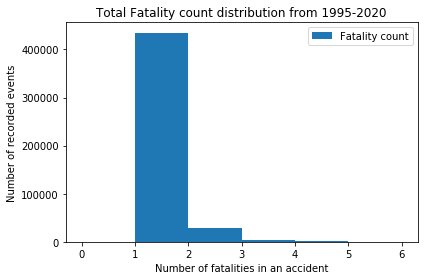

In [5]:
fig= plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.hist(x=d['accident']['FATALS'], label="Fatality count",bins=[0,1,2,3,4,5,6])

plt.legend(loc="upper right")
plt.title("Total Fatality count distribution from 1995-2020")
plt.xlabel('Number of fatalities in an accident')
plt.ylabel('Number of recorded events')
plt.tight_layout()
plt.show()

#### Create new variable called 'multiple_fatalities' that is 0 for single fatalities and 1 for anything greater than 1.

In [6]:
d['accident']['Multiple_fatalities'] = 0
d['accident']['Multiple_fatalities'][d['accident']['FATALS'] > 1] = 1
d['accident'] = d['accident'].drop('FATALS', 1)
d['accident'].head(5)

,DAY,MONTH,YEAR,DAY_WEEKNAME,HOUR,NHSNAME,ROUTENAME,RUR_URBNAME,HARM_EVNAME,TYP_INTNAME,REL_ROADNAME,LGT_CONDNAME,WEATHERNAME,LATITUDE,LONGITUD,DRUNK_DR,Multiple_fatalities
0,1,1,2015,Thursday,2,This section IS NOT on the NHS,State Highway,Rural,Embankment,Not an Intersection,On Roadside,Dark - Not Lighted,Clear,33.878653,-87.325328,1,0
1,1,1,2015,Thursday,22,This section IS ON the NHS,Interstate,Rural,Ditch,Not an Intersection,On Median,Dark - Not Lighted,Cloudy,34.910442,-86.908708,0,0
2,1,1,2015,Thursday,1,This section IS NOT on the NHS,U.S. Highway,Rural,Tree (Standing Only),Not an Intersection,On Roadside,Dark - Not Lighted,Clear,32.142006,-85.758456,1,0
3,4,1,2015,Sunday,0,This section IS NOT on the NHS,State Highway,Rural,Mail Box,Not an Intersection,On Roadside,Dark - Not Lighted,Cloudy,31.439814,-85.510300,1,0
4,7,1,2015,Wednesday,7,This section IS NOT on the NHS,U.S. Highway,Urban,Motor Vehicle In-Transport,T-Intersection,On Roadway,Daylight,Clear,31.319331,-85.515100,0,0


#### Make the features as categorial and apply one-hot encoding

In [7]:
col_to_encode = []
for i in d['accident'].columns:
    if "NAME" in i:
        col_to_encode.append(i)
    
d['accident'] = encode(d['accident'], col_to_encode)
d['accident'].head(5)

,DAY,MONTH,YEAR,HOUR,LATITUDE,LONGITUD,DRUNK_DR,Multiple_fatalities,DAY_WEEKNAME_Monday,DAY_WEEKNAME_Saturday,DAY_WEEKNAME_Sunday,DAY_WEEKNAME_Thursday,DAY_WEEKNAME_Tuesday,DAY_WEEKNAME_Wednesday,NHSNAME_This section IS ON the NHS,NHSNAME_Unknown if this section is on the NHS,ROUTENAME_Interstate,ROUTENAME_Local Street - Frontage Road,ROUTENAME_Local Street - Municipality,ROUTENAME_Local Street - Township,ROUTENAME_Other,ROUTENAME_State Highway,ROUTENAME_U.S. Highway,ROUTENAME_Unknown,RUR_URBNAME_Rural,RUR_URBNAME_Trafficway Not in State Inventory,RUR_URBNAME_Unknown,RUR_URBNAME_Urban,HARM_EVNAME_Bridge Overhead Structure,HARM_EVNAME_Bridge Pier or Support,HARM_EVNAME_Bridge Rail (Includes parapet),HARM_EVNAME_Building,HARM_EVNAME_Cable Barrier,HARM_EVNAME_Cargo/Equipment Loss or Shift (harmful to this vehicle),"HARM_EVNAME_Cargo/Equipment Loss, Shift, or Damage [harmful]",HARM_EVNAME_Concrete Traffic Barrier,HARM_EVNAME_Culvert,HARM_EVNAME_Curb,HARM_EVNAME_Ditch,HARM_EVNAME_Embankment,HARM_EVNAME_Fell/Jumped from Vehicle,HARM_EVNAME_Fence,HARM_EVNAME_Fire Hydrant,HARM_EVNAME_Fire/Explosion,HARM_EVNAME_Ground,HARM_EVNAME_Guardrail End,HARM_EVNAME_Guardrail Face,"HARM_EVNAME_Harmful Event, Details Not Reported",HARM_EVNAME_Immersion or Partial Immersion,HARM_EVNAME_Impact Attenuator/Crash Cushion,HARM_EVNAME_Injured In Vehicle (Non-Collision),HARM_EVNAME_Jackknife (harmful to this vehicle),HARM_EVNAME_Live Animal,HARM_EVNAME_Mail Box,HARM_EVNAME_Motor Vehicle In-Transport,"HARM_EVNAME_Motor Vehicle In-Transport Strikes or is Struck by Cargo, Persons or Objects Set-in-Motion from/by Another Motor Vehicle In Transport",HARM_EVNAME_Motor Vehicle in Motion Outside the Trafficway,HARM_EVNAME_Non-Motorist on Personal Conveyance,HARM_EVNAME_Object Fell From Motor Vehicle In-Transport,HARM_EVNAME_Object That Had Fallen From Motor Vehicle In-Transport,HARM_EVNAME_Other Fixed Object,HARM_EVNAME_Other Non-Collision,HARM_EVNAME_Other Object (not fixed),"HARM_EVNAME_Other Post, Other Pole or Other Supports",HARM_EVNAME_Other Traffic Barrier,HARM_EVNAME_Parked Motor Vehicle,"HARM_EVNAME_Pavement Surface Irregularity (Ruts, Potholes, Grates, etc.)",HARM_EVNAME_Pedalcyclist,HARM_EVNAME_Pedestrian,"HARM_EVNAME_Post, Pole or Other Supports",HARM_EVNAME_Railway Vehicle,HARM_EVNAME_Reported as Unknown,HARM_EVNAME_Ridden Animal or Animal Drawn Conveyance,HARM_EVNAME_Road Vehicle on Rails,HARM_EVNAME_Rollover/Overturn,HARM_EVNAME_Shrubbery,HARM_EVNAME_Snow Bank,HARM_EVNAME_Thrown or Falling Object,HARM_EVNAME_Traffic Sign Support,HARM_EVNAME_Traffic Signal Support,HARM_EVNAME_Tree (Standing Only),HARM_EVNAME_Unknown,HARM_EVNAME_Unknown Fixed Object,HARM_EVNAME_Unknown Object Not Fixed,HARM_EVNAME_Utility Pole/Light Support,HARM_EVNAME_Wall,HARM_EVNAME_Working Motor Vehicle,TYP_INTNAME_Four-Way Intersection,TYP_INTNAME_L-Intersection,TYP_INTNAME_Not Reported,TYP_INTNAME_Not an Intersection,TYP_INTNAME_Other Intersection Type,TYP_INTNAME_Reported as Unknown,TYP_INTNAME_Roundabout,TYP_INTNAME_T-Intersection,TYP_INTNAME_Traffic Circle,TYP_INTNAME_Unknown,TYP_INTNAME_Y-Intersection,REL_ROADNAME_Gore,REL_ROADNAME_In Parking Lane/Zone,REL_ROADNAME_Not Reported,REL_ROADNAME_Off Roadway-Location Unknown,REL_ROADNAME_On Median,REL_ROADNAME_On Roadside,REL_ROADNAME_On Roadway,REL_ROADNAME_On Shoulder,REL_ROADNAME_Outside Trafficway,REL_ROADNAME_Pedestrian Refuge Island or Traffic Island,REL_ROADNAME_Reported as Unknown,REL_ROADNAME_Separator,REL_ROADNAME_Unknown,LGT_CONDNAME_Dark - Not Lighted,LGT_CONDNAME_Dark - Unknown Lighting,LGT_CONDNAME_Dawn,LGT_CONDNAME_Daylight,LGT_CONDNAME_Dusk,LGT_CONDNAME_Not Reported,LGT_CONDNAME_Other,LGT_CONDNAME_Reported as Unknown,LGT_CONDNAME_Unknown,WEATHERNAME_Blowing Snow,WEATHERNAME_Clear,WEATHERNAME_Cloudy,"WEATHERNAME_Fog, Smog, Smoke",WEATHERNAME_Freezing Rain or Drizzle,WEATHERNAME_Not Reported,WEATHERNAME_Other,WEATHERNAME_Rain,WEATHERNAME_Reported as Unknown,WEATHERNAME_Severe Crosswinds,WEATHERNAME_Sleet or Hail,WEA

#### Plot preprocessed accident data - multiple fatality counts

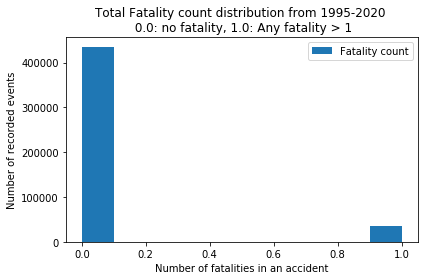

In [8]:
fig= plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.hist(x=d['accident']['Multiple_fatalities'], label="Fatality count")

plt.legend(loc="upper right")
plt.title("Total Fatality count distribution from 1995-2020 \n 0.0: no fatality, 1.0: Any fatality > 1")
plt.xlabel('Number of fatalities in an accident')
plt.ylabel('Number of recorded events')
plt.tight_layout()
plt.show()

#### Prepare inputs and outputs for training

In [9]:
y = d['accident']['Multiple_fatalities']
X = d['accident'].drop('Multiple_fatalities', axis=1)

#### Prepare and Fit RandomForestClassifier model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
model = RandomForestClassifier(max_depth=30,max_features=40)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Obtain performance metrics from trained model

In [11]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
confusion_matrix

Confusion Matrix:


array([[129449,    857],
       [ 10698,    136]])

In [13]:
accuracy_score = accuracy_score(y_test, y_pred)
print("Accuracy of Model:")
accuracy_score

Accuracy of Model:


0.9181309338245713

#### Variable Importance Plot - Global Interpretability

(50, 132)


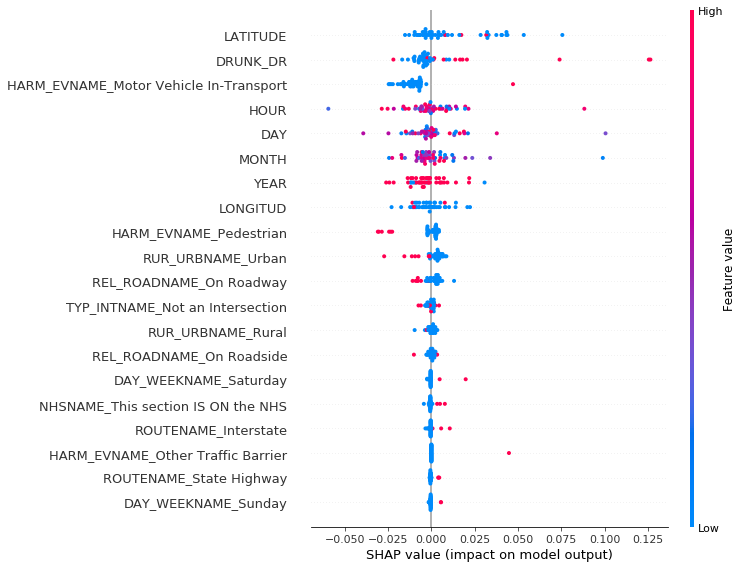

In [15]:
# SHAP plot lists the most significant variables in descending order.
# The horizontal location shows whether the effect of that value is associated with a higher or lower prediction
# Color shows whether that variable is high (in red) or low (in blue) for that observation

X_test_sample = X_test.iloc[:50]
print(X_test_sample.shape)
explainer = shap.TreeExplainer(model, feature_dependence="independent")
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values[1], X_test_sample)